In [79]:
library('RODBC')
library('quantmod')
library('PerformanceAnalytics')
library('colorspace')
library('extrafont')
library('lubridate')
source("/usr/common/config.R")
lcon <- odbcDriverConnect(sprintf("Driver={SQL Server};Server=%s;Database=%s;Uid=%s;Pwd=%s;", ldbserver, ldbname, ldbuser, ldbpassword), case = "nochange", believeNRows = TRUE)

In [80]:
#get the listing dates of all 'EQ' and 'BE' series stocks
allStarts<-sqlQuery(lcon, "select symbol, min(time_stamp), max(time_stamp) from px_history 
                            where (series='eq' or series='be')
                            and time_stamp >= '2010-01-01' and time_stamp < '2017-06-01'
                            group by symbol")

allStarts[,2]<-as.Date(allStarts[,2])
allStarts[,3]<-as.Date(allStarts[,3])
#remove delisted
allStarts<-allStarts[allStarts[,3] == max(allStarts[,3]),]

#print(allStarts)

In [81]:
cumRets<-data.frame(SYMBOL="", LDATE="", D0=0.0, D5=0.0, D10=0.0, D20=0.0, D50=0.0, D100=0.0, stringsAsFactors = F)

for(i in 1:length(allStarts[,1])){
    sym<-toString(allStarts[i,1])
    
    retSeries<-sqlQuery(lcon, sprintf("select time_stamp, daily_return from RETURN_SERIES_ALL 
                                        where symbol='%s' and time_stamp >='%s'", sym, allStarts[i,2]))
    
    retXts<-xts(retSeries[,2], as.Date(retSeries[,1]))
    
    ###! there should be a better way to do this !###
    d5<-ifelse(length(retXts) >= 6, Return.cumulative(retXts[2:6]), NA)
    d10<-ifelse(length(retXts) >= 11, Return.cumulative(retXts[2:11]), NA)
    d20<-ifelse(length(retXts) >= 21, Return.cumulative(retXts[2:21]), NA)
    d50<-ifelse(length(retXts) >= 51, Return.cumulative(retXts[2:51]), NA)
    d100<-ifelse(length(retXts) >= 101, Return.cumulative(retXts[2:101]), NA)
    
    cumRets<-rbind(cumRets, c(sym, toString(allStarts[i,2]), retXts[1]*100, d5*100, d10*100, d20*100, d50*100, d100*100))
}

cumRets<-cumRets[-1,]
#print(cumRets)

Warning message in sys.function(sys.parent()):
“closing unused RODBC handle 4”

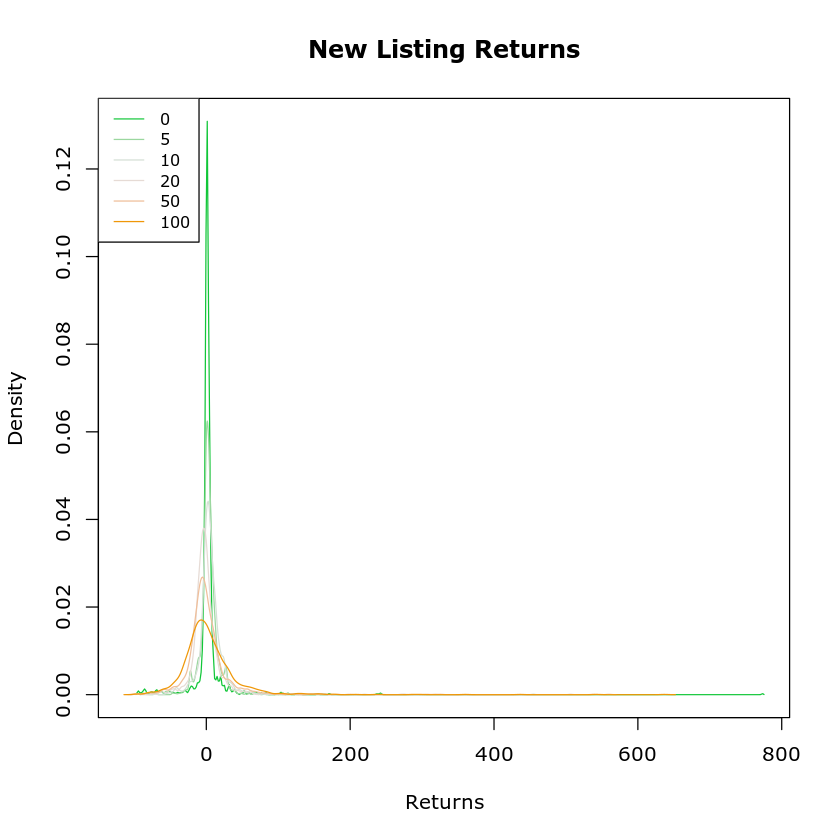

In [83]:
uLimit<-1000 #if cumulative returns exceed upper/lower limit, ignore them
lLimit<--1000

cumRets$D0<-as.numeric(cumRets$D0)
cumRets$D5<-as.numeric(cumRets$D5)
cumRets$D10<-as.numeric(cumRets$D10)
cumRets$D20<-as.numeric(cumRets$D20)
cumRets$D50<-as.numeric(cumRets$D50)
cumRets$D100<-as.numeric(cumRets$D100)

d0<-density(cumRets[cumRets$D0 < uLimit & cumRets$D0 > lLimit,]$D0, na.rm=T)
d5<-density(cumRets[cumRets$D5 < uLimit & cumRets$D5 > lLimit,]$D5, na.rm=T)
d10<-density(cumRets[cumRets$D10 < uLimit & cumRets$D10 > lLimit,]$D10, na.rm=T)
d20<-density(cumRets[cumRets$D20 < uLimit & cumRets$D20 > lLimit,]$D20, na.rm=T)
d50<-density(cumRets[cumRets$D50 < uLimit & cumRets$D50 > lLimit,]$D50, na.rm=T)
d100<-density(cumRets[cumRets$D100 < uLimit & cumRets$D100 > lLimit,]$D100, na.rm=T)

lineColors<-diverge_hcl(6, h = c(130, 43), c = 100, l = c(70, 90))

par(family='Verdana')
plot(range(d0$x, d5$x, d10$x, d20$x, d50$x, d100$x), range(d0$y, d5$y, d10$y, d20$y, d50$y, d100$y), type = "n", 
     ylab = "Density", xlab="Returns", main="New Listing Returns")

lines(d0, col=lineColors[1])
lines(d5, col=lineColors[2])
lines(d10, col=lineColors[3])
lines(d20, col=lineColors[4])
lines(d50, col=lineColors[5])
lines(d100, col=lineColors[6])
par(cex=0.8)
legend('topleft', legend=c('0', '5', '10', '20', '50', '100'), lty=1, col=lineColors)



In [93]:
cumRets$LDATE<-as.Date(cumRets$LDATE)
ctemp<-cumRets[!is.na(cumRets$D0),]

ctemp$D0<-round(ctemp$D0, 2)
ctemp$D5<-round(ctemp$D5, 2)
ctemp$D10<-round(ctemp$D10, 2)
ctemp$D20<-round(ctemp$D20, 2)
ctemp$D50<-round(ctemp$D50, 2)
ctemp$D100<-round(ctemp$D100, 2)

dIndex<-'D0'

c2010<-ctemp[year(ctemp$LDATE) == 2010 & ctemp[,dIndex] > lLimit & ctemp[,dIndex] < uLimit,]
c2011<-ctemp[year(ctemp$LDATE) == 2011 & ctemp[,dIndex] > lLimit & ctemp[,dIndex] < uLimit,]
c2012<-ctemp[year(ctemp$LDATE) == 2012 & ctemp[,dIndex] > lLimit & ctemp[,dIndex] < uLimit,]
c2013<-ctemp[year(ctemp$LDATE) == 2013 & ctemp[,dIndex] > lLimit & ctemp[,dIndex] < uLimit,]
c2014<-ctemp[year(ctemp$LDATE) == 2014 & ctemp[,dIndex] > lLimit & ctemp[,dIndex] < uLimit,]
c2015<-ctemp[year(ctemp$LDATE) == 2015 & ctemp[,dIndex] > lLimit & ctemp[,dIndex] < uLimit,]
c2016<-ctemp[year(ctemp$LDATE) == 2016 & ctemp[,dIndex] > lLimit & ctemp[,dIndex] < uLimit,]
c2017<-ctemp[year(ctemp$LDATE) == 2017 & ctemp[,dIndex] > lLimit & ctemp[,dIndex] < uLimit,]

print("ALL")
summary(ctemp[,dIndex])
print("c2010")
summary(c2010[,dIndex])
print("c2011")
summary(c2011[,dIndex])
print("c2012")
summary(c2012[,dIndex])
print("c2013")
summary(c2013[,dIndex])
print("c2014")
summary(c2014[,dIndex])
print("c2015")
summary(c2015[,dIndex])
print("c2016")
summary(c2016[,dIndex])
print("c2017")
summary(c2017[,dIndex])


[1] "ALL"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 -95.670   -0.495    1.220    2.997    4.145 1053.950 

[1] "c2010"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-93.370   0.000   1.430   2.764   3.810 171.000 

[1] "c2011"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -94.95  -25.18   -1.78    0.83    5.72  242.67 

[1] "c2012"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -93.32  -30.35   -2.76  -16.80    4.07   31.22 

[1] "c2013"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-88.2000  -5.6325  -1.1300  -2.7111   0.9025 112.5000 

[1] "c2014"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-70.6900   0.0025   1.4350  17.9486  13.2350 241.2600 

[1] "c2015"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-95.670  -4.460   0.665  -4.503   5.440  50.000 

[1] "c2016"


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-89.98000  -4.60000   0.69000  -0.05567  10.26000  83.72000 

[1] "c2017"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -65.52   -3.23    1.09   34.76   15.18  773.23 

In [85]:
c2010[order(c2010[,dIndex], decreasing=T),]

,SYMBOL,LDATE,D0,D5,D10,D20,D50,D100
26,UNITEDTEA,2010-01-08,171.00,4.53,-21.40,-36.69,-45.81,-47.31
707,WELINV,2010-09-20,130.82,27.76,44.43,41.37,10.94,-26.71
1094,ORIENTLTD,2010-03-03,125.08,72.44,63.70,61.67,48.79,65.66
357,BEARDSELL,2010-01-08,105.00,91.83,110.37,66.59,47.81,29.27
235,CAREERP,2010-10-06,102.63,-15.48,-21.18,-24.21,-43.37,-46.71
1087,BEDMUTHA,2010-10-14,75.64,39.88,-2.82,-31.76,-56.52,-43.85
669,PRAKASHSTL,2010-08-25,68.50,17.32,-12.49,-21.42,-19.96,-32.61
457,GRAVITA,2010-11-16,67.76,25.56,32.88,12.26,8.42,75.08
1116,ARSSINFRA,2010-03-03,63.88,7.33,25.67,34.48,58.43,57.91
1270,GALLISPAT,2010-10-11,62.10,-32.45,-35.47,-35.23,-35.60,-14.93


In [86]:
c2011[order(c2011[,dIndex], decreasing=T),]

,SYMBOL,LDATE,D0,D5,D10,D20,D50,D100
27,KICL,2011-01-14,242.67,-14.77,-6.79,0.55,-11.86,-22.13
78,BANARBEADS,2011-12-29,237.28,15.61,19.30,15.26,7.02,-8.95
1042,INDTERRAIN,2011-03-11,155.11,-22.20,-15.26,-9.87,-1.44,81.27
779,SUMMITSEC,2011-01-28,107.17,-22.57,-42.83,-42.63,-40.73,-57.66
1020,PGEL,2011-09-26,97.76,-39.32,-46.77,-47.74,-48.96,-54.58
718,TCIDEVELOP,2011-04-19,83.22,-22.22,-20.07,-31.70,-34.39,-42.47
1380,ELGIRUBCO,2011-08-10,81.33,-19.26,-21.91,-24.26,-28.09,-43.97
958,INVENTURE,2011-08-04,76.71,7.71,-20.05,-31.83,-24.23,-27.35
1345,UJAAS,2011-10-20,71.18,-19.72,-43.34,-66.76,-81.16,-78.69
115,PRAKASHCON,2011-10-04,66.67,-22.96,-26.63,2.20,-0.17,-62.37


In [87]:
c2012[order(c2012[,dIndex], decreasing=T),]

,SYMBOL,LDATE,D0,D5,D10,D20,D50,D100
440,SUNCLAYLTD,2012-10-23,31.22,27.12,32.18,31.27,51.81,33.72
1585,MCX,2012-03-09,25.65,0.04,-3.71,-3.05,-29.64,-20.50
1555,CARERATING,2012-12-26,23.01,0.15,0.12,0.76,-13.90,-20.19
1195,MTEDUCARE,2012-04-12,12.94,20.25,21.97,3.32,3.93,5.37
623,PCJEWELLER,2012-12-27,10.52,23.02,11.33,3.18,-14.98,-22.72
1493,THOMASCOTT,2012-01-30,9.79,-12.16,-6.00,-15.56,-30.15,-49.27
381,NDL,2012-03-23,7.61,-9.29,-5.05,-13.33,-14.75,8.69
1586,SPECIALITY,2012-05-30,6.40,13.35,36.50,33.99,9.68,12.73
1513,MORARJEE,2012-09-18,5.44,-23.81,-25.79,-26.59,-7.94,4.37
284,KITEX,2012-09-25,4.07,-5.91,6.86,-2.08,1.76,-7.34


In [88]:
c2013[order(c2013[,dIndex], decreasing=T),]

,SYMBOL,LDATE,D0,D5,D10,D20,D50,D100
794,GSCLCEMENT,2013-05-15,112.50,25.41,5.88,-12.47,-27.45,-26.46
1028,JUSTDIAL,2013-06-05,15.54,3.86,6.03,3.80,7.95,71.55
1210,IBULHSGFIN,2013-07-23,4.95,-22.59,-24.59,-26.64,-24.57,-12.72
1341,MOHITIND,2013-03-14,3.70,-3.35,-17.40,-21.38,-26.73,-14.99
566,ATULAUTO,2013-06-26,2.01,-0.64,-1.82,-2.05,-15.36,53.89
1550,VIVIDHA,2013-05-21,1.39,-2.92,-8.31,-20.49,-39.49,-60.45
438,NIFTYIWIN,2013-04-05,0.91,4.66,6.23,6.20,7.47,1.05
25,ABFRL,2013-07-17,0.88,4.50,0.05,-33.83,-29.33,-38.25
1207,LYPSAGEMS,2013-11-05,0.68,2.48,0.34,-0.47,-1.34,4.16
445,NIF100IWIN,2013-08-27,0.31,1.55,2.82,3.42,4.35,-1.38


In [89]:
c2014[order(c2014[,dIndex], decreasing=T),]

,SYMBOL,LDATE,D0,D5,D10,D20,D50,D100
908,AGRITECH,2014-01-28,241.26,-22.33,-39.54,-63.30,-80.37,-75.11
1113,NATHBIOGEN,2014-01-28,103.88,27.38,61.91,162.62,326.19,297.14
385,SNOWMAN,2014-09-12,69.79,18.42,13.35,-1.38,34.90,5.20
1100,GULFOILLUB,2014-07-31,52.46,5.20,7.73,13.03,21.89,104.74
1058,SHARDACROP,2014-09-23,48.04,12.92,11.28,13.60,11.58,16.48
223,WONDERLA,2014-05-09,26.24,8.17,22.75,34.89,45.56,82.34
266,RELCONS,2014-04-22,20.27,-21.59,-12.84,-9.19,-6.54,-3.89
77,CPSEETF,2014-04-04,10.89,1.24,3.77,7.08,33.18,33.59
36,SUPERHOUSE,2014-09-26,4.89,6.15,-2.59,-2.47,-23.11,-7.97
652,CIGNITITEC,2014-10-13,4.70,-1.47,0.22,-0.91,-3.19,-3.52


In [90]:
c2015[order(c2015[,dIndex], decreasing=T),]

,SYMBOL,LDATE,D0,D5,D10,D20,D50,D100
429,LALPATHLAB,2015-12-23,50.00,-2.49,-2.57,-11.64,4.12,16.73
11,VRLLOG,2015-04-30,43.46,-4.45,-9.03,5.19,11.59,35.25
268,JMA,2015-03-16,40.66,-20.55,-30.57,-10.58,-32.75,-2.31
1427,PILANIINVS,2015-12-09,38.45,-11.23,8.75,-4.16,-24.07,-14.12
1259,INOXWIND,2015-04-09,34.89,8.10,-4.11,-0.87,-2.22,-16.50
806,ALKEM,2015-12-23,31.59,7.49,6.20,-0.95,-5.10,-9.61
1128,APOLSINHOT,2015-02-16,31.23,27.61,62.04,103.27,43.06,29.40
892,ANANDAMRUB,2015-12-01,28.77,26.74,120.51,97.07,56.14,60.34
187,SYNGENE,2015-08-11,24.22,18.21,-0.11,7.63,20.11,31.81
67,VIPULLTD,2015-04-23,18.55,-13.33,-18.46,-18.71,-18.54,-25.58


In [91]:
c2016[order(c2016[,dIndex], decreasing=T),]

,SYMBOL,LDATE,D0,D5,D10,D20,D50,D100
1005,TMRVL,2016-12-14,83.72,-14.44,-4.20,-14.39,-16.51,-14.44
776,QUESS,2016-07-12,58.71,119.35,454.76,506.52,538.22,636.92
631,SFL,2016-12-09,41.37,-7.04,-8.78,-6.40,1.42,37.11
650,THYROCARE,2016-05-09,38.74,161.02,151.89,146.73,125.85,154.23
147,ENDURANCE,2016-10-19,37.06,-4.91,-5.75,-15.44,-10.09,9.20
593,NH,2016-01-06,34.78,-3.56,-10.61,-4.47,-12.85,-7.97
255,RBLBANK,2016-08-31,33.07,39.08,37.40,32.57,49.21,73.84
1518,ADVENZYMES,2016-08-01,31.48,164.68,145.98,153.14,242.97,236.67
1070,GROBTEA,2016-07-14,31.13,59.38,101.93,20.99,-7.64,-7.96
1244,SHRIPISTON,2016-06-09,25.00,80.86,130.80,275.87,559.84,436.55


In [92]:
c2017[order(c2017[,dIndex], decreasing=T),]

,SYMBOL,LDATE,D0,D5,D10,D20,D50,D100
963,DOLLAR,2017-04-21,773.23,13.73,27.82,16.13,NA,NA
1221,DMART,2017-03-21,114.58,-2.00,-1.47,17.88,21.52,NA
785,SHANKARA,2017-04-05,37.49,19.84,15.93,11.49,NA,NA
1449,BSE,2017-02-03,32.66,-6.00,-9.54,-11.21,-5.24,NA
454,HUDCO,2017-05-19,20.92,0.55,0.62,NA,NA,NA
311,PRICOLLTD,2017-02-10,18.40,-16.93,-15.91,-27.15,-21.88,NA
1446,BHANDARI,2017-01-30,18.37,20.69,5.17,0.00,-10.34,NA
1574,RADIOCITY,2017-03-17,11.98,-3.81,-3.31,-8.42,-6.50,NA
1243,HISARMETAL,2017-01-05,9.96,21.43,51.57,25.96,79.44,72.47
1162,BHAGYANGR,2017-05-17,9.24,-10.34,-2.82,NA,NA,NA
